In [1]:
import sys
sys.path.append('..')

In [2]:
import tensorflow as tf
from tensorflow import keras

import config
from losses import MSE
from models import unet
from capsa import DropoutWrapper

from utils import (
    notebook_select_gpu,
    load_depth_data,
    load_apollo_data,
    get_normalized_ds,
    visualize_depth_map,
    plot_loss,
    gen_ood_comparison,
    gen_calibration_plot,
)

notebook_select_gpu(0)

## Train model

In [3]:
(x_train, y_train), (x_test, y_test) = load_depth_data()

ds_train = get_normalized_ds(x_train[: config.N_TRAIN], y_train[: config.N_TRAIN])
ds_test = get_normalized_ds(x_test[: config.N_TEST], y_test[: config.N_TEST])

_, (x_ood, y_ood) = load_apollo_data()
ds_ood = get_normalized_ds(x_ood, y_ood)

2022-12-08 17:39:58.719395: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.
2022-12-08 17:39:59.125752: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.


In [5]:
model_name = "dropout"

base_model = unet(drop_prob=0.1)
# don't add dropout in the wrapper because our model already contains dropout layers
model = DropoutWrapper(base_model, p=0.0)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.LR),
    loss=MSE,
)

In [6]:
history = model.fit(
    ds_train,
    epochs=config.EP,
    validation_data=ds_test,
)

Epoch 1/20


2022-12-08 09:04:11.297085: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-08 09:04:11.297472: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


64/64 [==============================] - 11s 127ms/step - dropout_loss: 0.2022 - val_dropout_loss: 0.0640
Epoch 2/20
64/64 [==============================] - 8s 122ms/step - dropout_loss: 0.0558 - val_dropout_loss: 0.0450
Epoch 3/20
64/64 [==============================] - 8s 122ms/step - dropout_loss: 0.0397 - val_dropout_loss: 0.0315
Epoch 4/20
64/64 [==============================] - 8s 123ms/step - dropout_loss: 0.0331 - val_dropout_loss: 0.0253
Epoch 5/20
64/64 [==============================] - 8s 123ms/step - dropout_loss: 0.0251 - val_dropout_loss: 0.0247
Epoch 6/20
64/64 [==============================] - 8s 123ms/step - dropout_loss: 0.0207 - val_dropout_loss: 0.0180
Epoch 7/20
64/64 [==============================] - 8s 123ms/step - dropout_loss: 0.0150 - val_dropout_loss: 0.0123
Epoch 8/20
64/64 [==============================] - 8s 123ms/step - dropout_loss: 0.0117 - val_dropout_loss: 0.0105
Epoch 9/20
64/64 [==============================] - 8s 123ms/step - dropout_loss: 

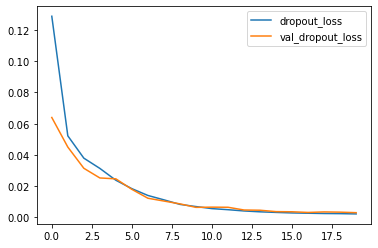

In [9]:
plot_loss(history)

/home/iaroslavelistratov/depth/capsa/experiments/notebooks/../utils.py:61: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad(color="black")


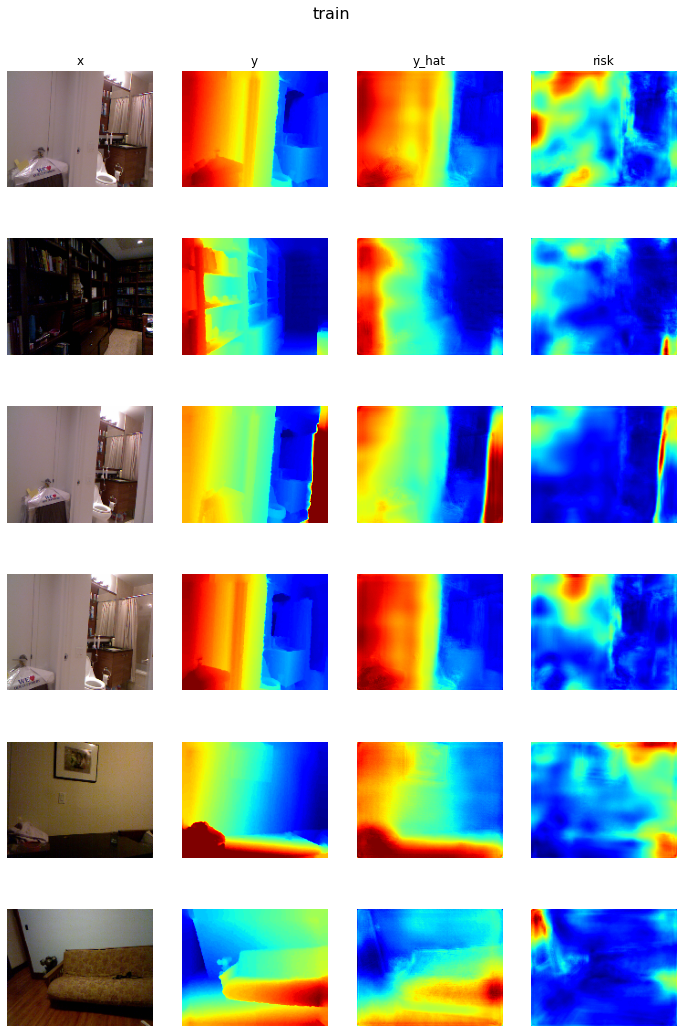

In [11]:
visualize_depth_map(model, ds_train, "train")

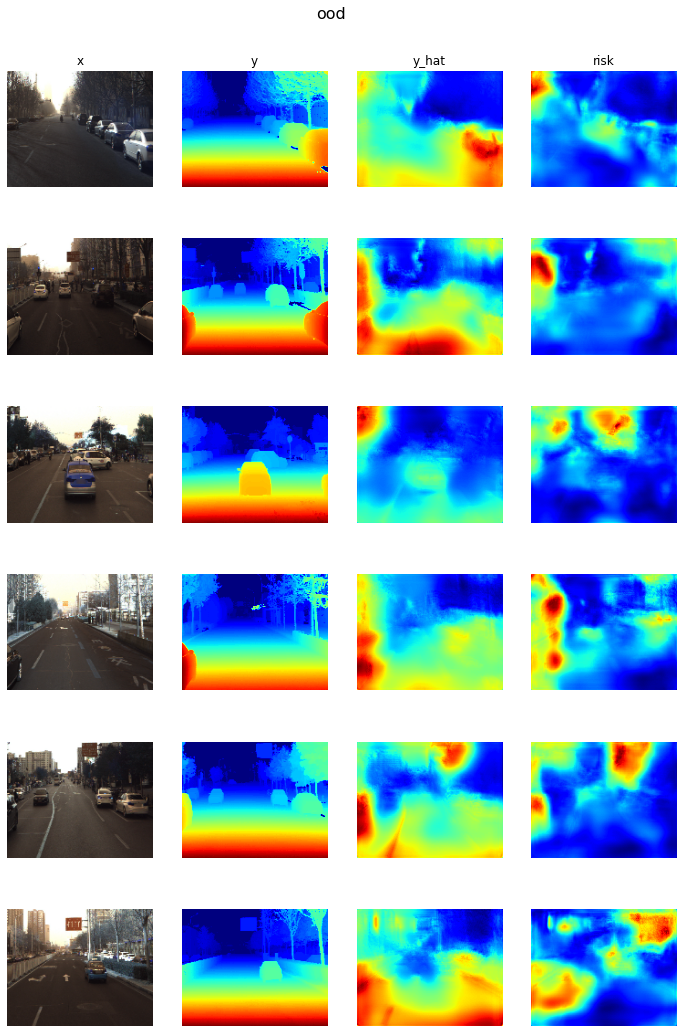

In [12]:
visualize_depth_map(model, ds_ood, "ood")

## Load trained model

In [4]:
from utils import load_model, select_best_checkpoint

path, model_name = select_best_checkpoint('/home/iaroslavelistratov/results/dropout/20221208-192959')
trained_model = load_model(path, model_name, ds_train, quite=False)

2022-12-08 17:40:07.532575: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.
2022-12-08 17:40:09.079840: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-08 17:40:09.080241: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Successfully loaded weights from /home/iaroslavelistratov/results/dropout/20221208-192959/checkpoints/0.000617vloss_25806iter.tf.


/home/iaroslavelistratov/depth/capsa/experiments/notebooks/../utils.py:61: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad(color="black")


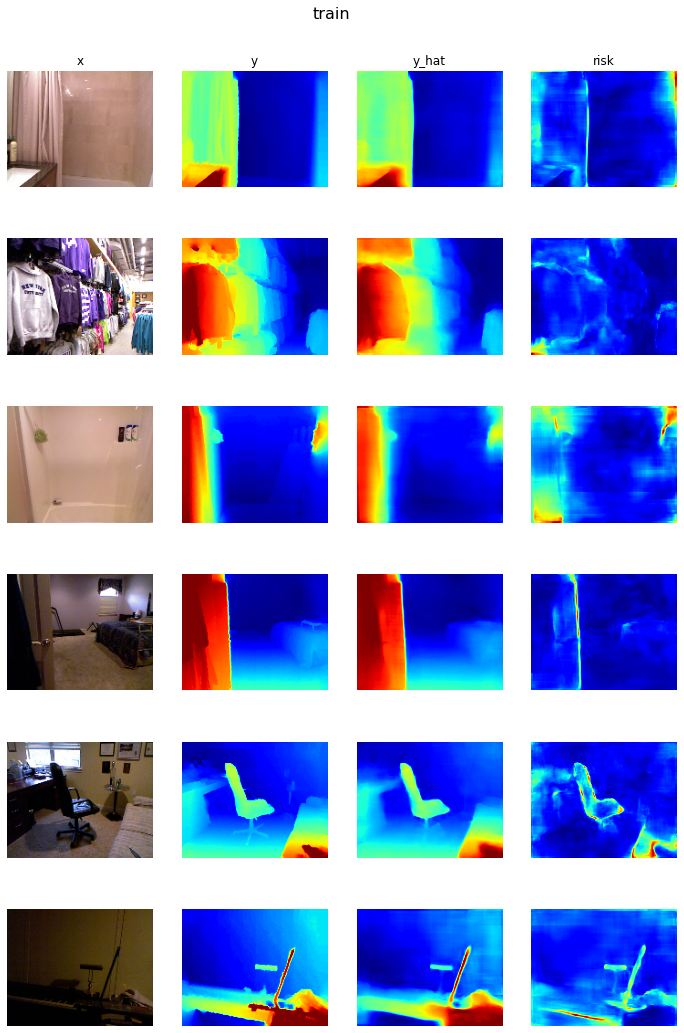

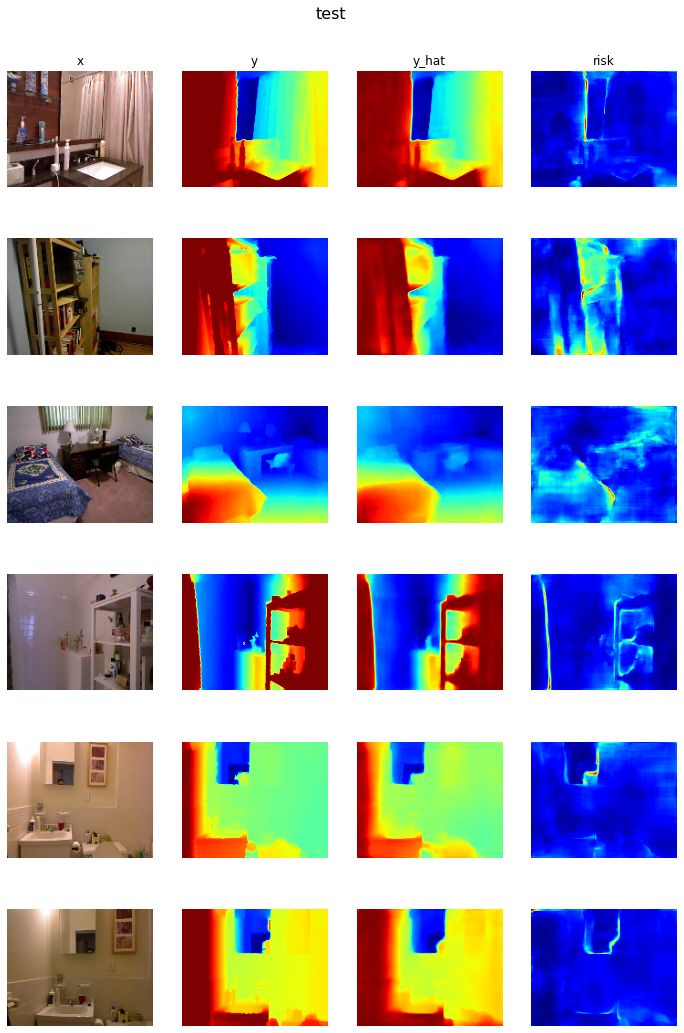

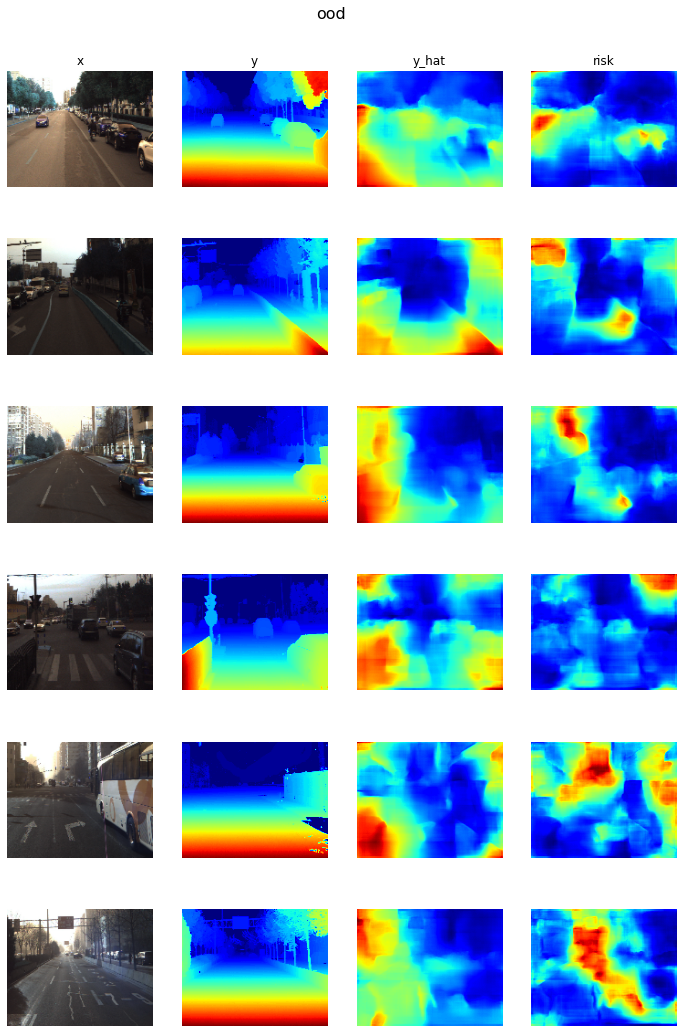

In [6]:
from utils import visualize_depth_map

visualize_depth_map(trained_model, ds_train, "train")
visualize_depth_map(trained_model, ds_test, "test")
visualize_depth_map(trained_model, ds_ood, "ood")

### Calibration curve

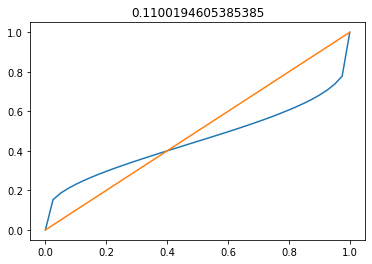

In [8]:
from utils import gen_calibration_plot
gen_calibration_plot(trained_model, ds_test)

### OOD plot

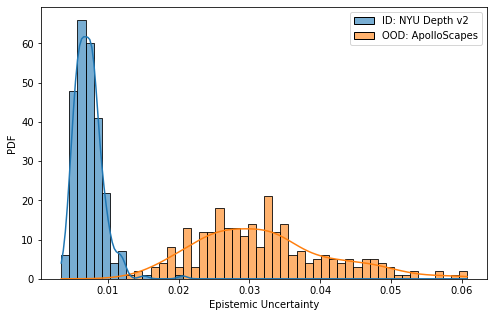

In [9]:
from utils import gen_ood_comparison
gen_ood_comparison(ds_test, ds_ood, trained_model, T=5, reduce='per_img', is_show=True)